In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 3)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
from scipy.special import logit, expit

# Super Learner Import
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [2]:
df_mindset = pd.read_csv('learning_mindset.csv')
print(df_mindset.info())
df_mindset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schoolid                10391 non-null  int64  
 1   intervention            10391 non-null  int64  
 2   achievement_score       10391 non-null  float64
 3   success_expect          10391 non-null  int64  
 4   ethnicity               10391 non-null  int64  
 5   gender                  10391 non-null  int64  
 6   frst_in_family          10391 non-null  int64  
 7   school_urbanicity       10391 non-null  int64  
 8   school_mindset          10391 non-null  float64
 9   school_achievement      10391 non-null  float64
 10  school_ethnic_minority  10391 non-null  float64
 11  school_poverty          10391 non-null  float64
 12  school_size             10391 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 1.0 MB
None


,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277,6,4,2,1,4,0.335,0.649,-1.311,0.224,-0.427
1,76,1,-0.450,4,12,2,1,4,0.335,0.649,-1.311,0.224,-0.427
2,76,1,0.770,6,4,2,0,4,0.335,0.649,-1.311,0.224,-0.427
3,76,1,-0.122,6,4,2,0,4,0.335,0.649,-1.311,0.224,-0.427
4,76,1,1.526,6,4,1,0,4,0.335,0.649,-1.311,0.224,-0.427


In [3]:
# Convert categorical values to binary indicators (one-hot)
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

df_categ = pd.concat([
    df_mindset.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(df_mindset[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

In [4]:
T = 'intervention'
Y = 'achievement_score'
X = df_categ.columns.drop([T, Y])

/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


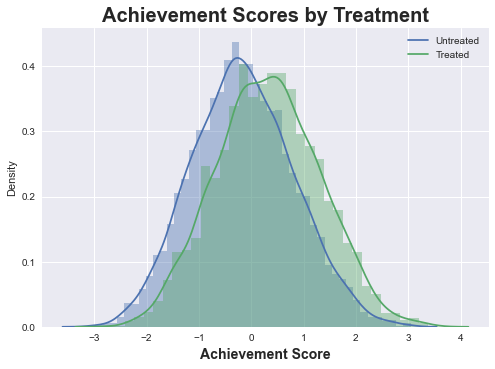

In [5]:
sns.distplot(df_mindset['achievement_score'][df_categ['intervention'] == 0], kde=True)
sns.distplot(df_mindset['achievement_score'][df_categ['intervention'] == 1], kde=True)
plt.title("Achievement Scores by Treatment", fontsize=20, fontweight = 'bold')
plt.xlabel('Achievement Score', fontsize=14, fontweight = 'bold', labelpad=5)
plt.legend(['Untreated', 'Treated'])
plt.savefig('Naive.png')

In [6]:

# create a list of base-models
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(ElasticNet())
	models.append(SVR(gamma='scale'))
	models.append(DecisionTreeRegressor())
	models.append(KNeighborsRegressor())
	models.append(AdaBoostRegressor())
	models.append(BaggingRegressor(n_estimators=10))
	models.append(RandomForestRegressor(n_estimators=10))
	models.append(ExtraTreesRegressor(n_estimators=10))
	return models
 
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)
 
# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model
 
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))
 
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)
 
# create the inputs and outputs
X = df_categ[df_categ.columns.drop([Y])].to_numpy()
y = df_categ[Y].to_numpy()
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

Train (5195, 31) (5195,) Test (5196, 31) (5196,)
Meta  (5195, 9) (5195,)
LinearRegression: RMSE 0.831
ElasticNet: RMSE 0.999
SVR: RMSE 0.853
DecisionTreeRegressor: RMSE 1.045
KNeighborsRegressor: RMSE 0.887
AdaBoostRegressor: RMSE 0.825
BaggingRegressor: RMSE 0.891
RandomForestRegressor: RMSE 0.895
ExtraTreesRegressor: RMSE 0.963
Super Learner: RMSE 0.805


In [7]:
# IPW
def IPW(df, X, T, Y,true_ps = True):

    if true_ps:
        p_scores = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    else:
        p_scores = np.random.uniform(0.1, 0.9, df.shape[0])

    df_ps = df.assign(propensity_score=p_scores)

    weight = ((df_ps["intervention"]-df_ps["propensity_score"]) / (df_ps["propensity_score"]*(1-df_ps["propensity_score"])))

    weight_t = 1/df_ps.query("intervention==1")["propensity_score"]
    weight_nt = 1/(1-df_ps.query("intervention==0")["propensity_score"])

    y1 = sum(df_ps.query("intervention==1")["achievement_score"]*weight) / len(df_ps)
    y0 = sum(df_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(df_ps)

    return np.mean(weight * df_ps["achievement_score"]), p_scores, df_ps

In [8]:
df_predict = df_categ.copy()
X = df_predict[df_predict.columns.drop([Y])].to_numpy()
Q_a = super_learner_predictions(X, models, meta_model)
df_predict['intervention'] = 0
X = df_predict[df_predict.columns.drop([Y])].to_numpy()
Q_0 = super_learner_predictions(X, models, meta_model)
df_predict['intervention'] = 1
X = df_predict[df_predict.columns.drop([Y])].to_numpy()
Q_1 = super_learner_predictions(X, models, meta_model)

df_tmle = pd.DataFrame([df_categ[Y].to_numpy(),df_categ[T].to_numpy(), Q_a,Q_0,Q_1]).T
df_tmle.columns = ['Y','D','Q_a','Q_0','Q_1']

In [9]:
df_tmle['Q_1'].mean() - df_tmle['Q_0'].mean()

0.3946490800139494

In [10]:
T = 'intervention'
Y = 'achievement_score'
X = df_categ.columns.drop([T, Y])
ate, ps,_ = IPW(df_categ, X, T, Y)

df_tmle['H_1'] = 1/ps
df_tmle['H_0'] = -1/(1-ps)
df_tmle['H_a'] = df_tmle['D'] * df_tmle['H_1'] + (1-df_tmle['D']) * df_tmle['H_0']

In [11]:
df_tmle.dtypes

Y      float64
D      float64
Q_a    float64
Q_0    float64
Q_1    float64
H_1    float64
H_0    float64
H_a    float64
dtype: object

In [12]:
sm.GLM(logit, df_tmle, family=sm.families.Binomial())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
eps_fit = np.polyfit(df_tmle['H_a'], df_tmle['Y'] - df_tmle['Q_a'], 1)[0]

In [ ]:
df_tmle['Q_0_hat'] = df_tmle['Q_0'] + eps_fit * df_tmle['H_0']
df_tmle['Q_1_hat'] = df_tmle['Q_1'] + eps_fit * df_tmle['H_1']
df_tmle['Q_a_hat'] = df_tmle['Q_a'] + eps_fit * df_tmle['H_a']
TMLE_ate = df_tmle['Q_1_hat'].mean() - df_tmle['Q_0_hat'].mean()

In [ ]:
df_tmle

,Y,D,Q_a,Q_0,Q_1,H_1,H_0,H_a,Q_0_hat,Q_1_hat,Q_a_hat
0,0.277,1.0,0.341,-0.089,0.341,3.182,-1.458,3.182,-0.086,0.334,0.334
1,-0.450,1.0,-0.485,-0.533,-0.485,3.824,-1.354,3.824,-0.529,-0.494,-0.494
2,0.770,1.0,0.410,0.212,0.410,2.918,-1.521,2.918,0.216,0.403,0.403
3,-0.122,1.0,0.410,0.212,0.410,2.918,-1.521,2.918,0.216,0.403,0.403
4,1.526,1.0,0.718,0.196,0.718,2.730,-1.578,2.730,0.200,0.712,0.712
...,...,...,...,...,...,...,...,...,...,...,...
10386,0.809,0.0,0.514,0.514,0.814,3.057,-1.486,-1.486,0.518,0.807,0.518
10387,-0.156,0.0,0.514,0.514,0.814,3.057,-1.486,-1.486,0.518,0.807,0.518
10388,0.371,0.0,-0.987,-0.987,-0.586,3.996,-1.334,-1.334,-0.984,-0.596,-0.984
10389,-0.396,0.0,-0.491,-0.491,-0.137,3.278,-1.439,-1.439,-0.487,-0.145,-0.487


In [ ]:
df_tmle['Q_1'].mean() - df_tmle['Q_0'].mean()

0.3630129102208053

In [ ]:
IF = (df_tmle['Y'] - df_tmle['Q_a_hat']) * df_tmle['H_a'] + df_tmle['Q_1_hat'] - df_tmle['Q_0_hat'] - TMLE_ate

In [ ]:
np.sqrt(IF.var()/df_tmle.shape[0])

0.016381395456470823